In [1]:
import logging
import numpy as np
import pandas as pd
import h5py as h5
from collections import namedtuple
import matplotlib.pyplot as plt
import datetime as dt

logging.basicConfig(
    level='INFO',
    format='[%(asctime)s %(levelname)s] %(message)s'
)

# Load Data

Load from one file

In [21]:
#datadir = 'data/jz7w/evensplitlayers/'
#infile = 'barrel.h5' 
datadir = 'data/'
infile = '811_evensplit_realfrac_train.h5'

logging.info(f'Loading data from data/{infile}')

with h5.File(datadir+infile, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

[2020-08-25 18:11:59,775 INFO] Loading data from data/811_evensplit_equalfrac_train.h5


OSError: Unable to open file (unable to open file: name = 'data/811_evensplit_equalfrac_train.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Exploring data structure

In [22]:
outDir = 'output/sample_distributions/'+infile.split('.')[0]+'/'
if not os.path.exists(outDir):
    os.mkdir(outDir)

EndcapMask = data_x[:,57]!=0
BarrelMask = np.logical_and(data_x[:,56]!=0, data_x[:,57]==0)
IBLMask = np.logical_and(data_x[:,56]==0, data_x[:,57]==0)

data_y_copy = np.copy(data_y)
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]

data_x.shape

(10000000, 60)

Plot layer distribution

[2020-08-25 18:05:40,005 INFO] [10000000, 0, 0]


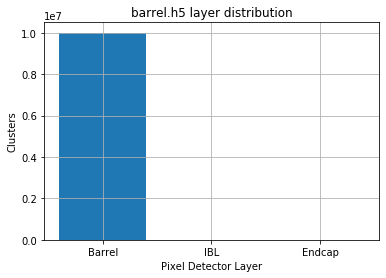

In [16]:
zeros = np.empty((data_x.shape[0], 1))
hist = [zeros[BarrelMask].shape[0], zeros[IBLMask].shape[0], zeros[EndcapMask].shape[0]]
bins = ['Barrel', 'IBL', 'Endcap']
logging.info(hist)

plt.bar(bins, hist)
plt.ylabel(f"Clusters")
plt.xlabel(f"Pixel Detector Layer")
plt.grid(True)
plt.title(f'{infile} layer distribution')
plt.savefig(f'{outDir}{infile}_layer_distribution.png')
plt.show()
plt.close()

plot total label distribution

[2020-08-25 18:05:40,395 INFO] (array([3300000, 3300000, 3400000], dtype=int64), array([0. , 1.5, 2.5, 3.5]))


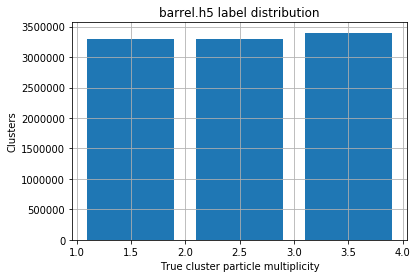

In [17]:
hist = np.histogram(data_y_copy, bins=[0,1.5,2.5,3.5])
logging.info(hist)

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} label distribution')
plt.savefig(f'{outDir}{infile}_label_distribution.png')
plt.show()
plt.close()

Plot label distribution for each layer

[2020-08-25 18:05:40,867 INFO] (array([0, 0, 0], dtype=int64), array([0. , 1.5, 2.5, 3.5]))


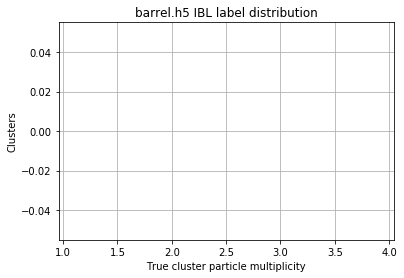

In [18]:
hist = np.histogram(data_y_copy[IBLMask], bins=[0,1.5,2.5,3.5])
logging.info(hist)

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} IBL label distribution')
plt.savefig(f'{outDir}{infile}_IBL_label_distribution.png')
plt.show()
plt.close()

[2020-08-25 18:05:41,371 INFO] (array([3300000, 3300000, 3400000], dtype=int64), array([0. , 1.5, 2.5, 3.5]))


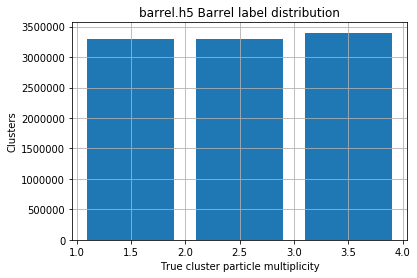

In [19]:
hist = np.histogram(data_y_copy[BarrelMask], bins=[0,1.5,2.5,3.5])
logging.info(hist)

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} Barrel label distribution')
plt.savefig(f'{outDir}{infile}_Barrel_label_distribution.png')
plt.show()
plt.close()

[2020-08-25 18:05:41,710 INFO] (array([0, 0, 0], dtype=int64), array([0. , 1.5, 2.5, 3.5]))


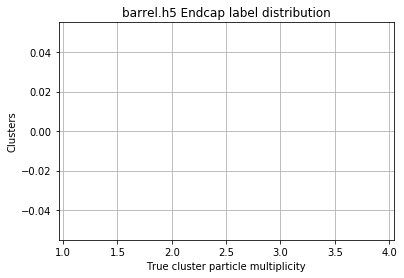

In [20]:
hist = np.histogram(data_y_copy[EndcapMask], bins=[0,1.5,2.5,3.5])
logging.info(hist)

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} Endcap label distribution')
plt.savefig(f'{outDir}{infile}_Endcap_label_distribution.png')
plt.show()
plt.close()

# Shuffle Data
### Shuffle each layer sample

In [2]:
datadir = 'data/jz7w/evensplitlayers/'
infiles = ['barrel.h5', 'ibl.h5', 'endcap.h5']

In [4]:
logging.info(f'Loading data from directory {datadir}')
for i, layerFile in enumerate(infiles):
    rng = np.random.default_rng(seed=42)
    logging.info(f'Loading data from {layerFile}')
    with h5.File(datadir + layerFile, 'r') as data:
        data_x = data['input'][()]
        data_y = data['target'][()]

    logging.info('Shuffling')
    s = np.arange(data_x.shape[0])
    rng.shuffle(s)
    data_x = data_x[s]
    data_y = data_y[s]

    outfile = '{}_shuffled.h5'.format(layerFile.split('.')[0])
    logging.info(f'Saving {outfile}')
    with h5.File(datadir + outfile, 'w') as hfile:
        hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
        hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

[2020-08-25 16:40:42,118 INFO] Loading data from directory data/jz7w/evensplitlayers/
[2020-08-25 16:40:42,120 INFO] Loading data from barrel.h5
[2020-08-25 16:40:51,651 INFO] Shuffled
[2020-08-25 16:40:55,770 INFO] Saved barrel_shuffled.h5
[2020-08-25 16:41:27,930 INFO] Loading data from ibl.h5
[2020-08-25 16:41:37,756 INFO] Shuffled
[2020-08-25 16:41:41,913 INFO] Saved ibl_shuffled.h5
[2020-08-25 16:42:13,370 INFO] Loading data from endcap.h5
[2020-08-25 16:42:18,387 INFO] Shuffled
[2020-08-25 16:42:20,425 INFO] Saved endcap_shuffled.h5


# Save Training Sample

Equal Layers, Equal Fraction. Duplicate any insufficient data to reach a certain number of labels per layer.

In [8]:
datadir = 'data/jz7w/evensplitlayers/'
infiles = ['barrel.h5', 'ibl.h5', 'endcap.h5']
outfile = '824_evensplit_equalfrac_train.h5'
total_train_clusters = int(20e6)

clusters_per_layer = int(total_train_clusters/3)
labels_per_layer = int(clusters_per_layer/3)
init_shapes = [(0,60), (0,3)]

In [9]:
with h5.File('data/' + outfile, 'w') as hfile:
    hfile.create_dataset('input', data=np.empty(init_shapes[0], dtype=np.float32), compression='gzip', chunks=True, maxshape=(None,init_shapes[0][1]))
    hfile.create_dataset('target', data=np.empty(init_shapes[1], dtype=np.float32), compression='gzip', chunks=True, maxshape=(None,init_shapes[1][1]))

for layerFile in infiles:
    logging.info(f'Loading {}_shuffled.h5'.format(layerFile.split('.')[0])
    filename = '{}_shuffled.h5'.format(layerFile.split('.')[0])
    with h5.File(datadir + filename, 'r') as data:
        data_x = data['input'][()]
        data_y = data['target'][()]
    '''
    EndcapMask = data_x[:,57]!=0
    BarrelMask = np.logical_and(data_x[:,56]!=0, data_x[:,57]==0)
    IBLMask = np.logical_and(data_x[:,56]==0, data_x[:,57]==0)
    '''
    data_y_estimated = data_y[:,0] + 2*data_y[:,1] + 3*data_y[:,2]
    particleMask = [data_y_estimated == 1, data_y_estimated == 2, data_y_estimated == 3]
    hist = np.histogram(data_y_estimated, bins=[0,1.5,2.5,3.5])
    logging.info('Number of clusters per label \n1-particle: {} \n2-particle: {} \n3-particle: {}'.format(*hist[0]))

    add_per_label = [labels_per_layer - i for i in hist[0]]
    logging.info('Add clusters per label \n1-particle: {} \n2-particle: {} \n3-particle: {}'.format(*add_per_label))

    data_x_new = np.empty((0,data_x.shape[1]))
    data_y_new = np.empty((0,data_y.shape[1]))
    logging.info(f'Getting clusters from {filename}')
    for i,add in enumerate(add_per_label):
        if add <= 0:
            data_x_new = np.append(data_x_new, data_x[particleMask[i]][:labels_per_layer], axis=0)
            data_y_new = np.append(data_y_new, data_y[particleMask[i]][:labels_per_layer], axis=0)
        else:
            add_index = np.remainder(np.array(range(labels_per_layer)), np.array(data_x[particleMask[i]].shape[0]))
            data_x_new = np.append(data_x_new, data_x[particleMask[i]][add_index], axis=0)
            data_y_new = np.append(data_y_new, data_y[particleMask[i]][add_index], axis=0)
    
    del data_x, data_y

    logging.info('Saving clusters to data/' + outfile)
    with h5.File('data/' + outfile, 'a') as hfile:
        hfile['input'].resize((hfile['input'].shape[0] + data_x_new.shape[0]), axis=0)
        hfile['input'][-data_x_new.shape[0]:] =  data_x_new.astype(np.float32)
        hfile['target'].resize((hfile['target'].shape[0] + data_y_new.shape[0]), axis=0)
        hfile['target'][-data_y_new.shape[0]:] =  data_y_new.astype(np.float32)

    del data_x_new, data_y_new


[2020-08-25 16:48:49,315 INFO] Loading barrel.h5
[2020-08-25 16:48:58,845 INFO] Number of clusters per label 
1-particle: 3300000 
2-particle: 3300000 
3-particle: 3400000
[2020-08-25 16:48:58,846 INFO] Add clusters per label 
1-particle: -1077778 
2-particle: -1077778 
3-particle: -1177778
[2020-08-25 16:48:58,847 INFO] Getting clusters from barrel_shuffled.h5
[2020-08-25 16:49:04,049 INFO] Saving clusters to data/824_evensplit_equalfrac_train.h5
[2020-08-25 16:49:27,411 INFO] Loading ibl.h5
[2020-08-25 16:49:37,113 INFO] Number of clusters per label 
1-particle: 3300000 
2-particle: 3300000 
3-particle: 3400000
[2020-08-25 16:49:37,113 INFO] Add clusters per label 
1-particle: -1077778 
2-particle: -1077778 
3-particle: -1177778
[2020-08-25 16:49:37,114 INFO] Getting clusters from ibl_shuffled.h5
[2020-08-25 16:49:42,223 INFO] Saving clusters to data/824_evensplit_equalfrac_train.h5
[2020-08-25 16:50:05,557 INFO] Loading endcap.h5
[2020-08-25 16:50:10,602 INFO] Number of clusters per

Equal layers, real labels

In [6]:
datadir = 'data/jz7w/evensplitlayers/'
infiles = ['barrel_equalfrac.h5', 'ibl_equalfrac.h5', 'endcap_equalfrac.h5']
layer_clusters = int(4e6)
init_shapes = [(0,60), (0,3)]

data_x = np.empty(init_shapes[0])
data_y = np.empty(init_shapes[1])
for i, layerFile in enumerate(infiles):
    logging.info('Loading clusters from {}'.format(layerFile))
    with h5.File('{}{}'.format(datadir, layerFile), 'r') as data:
        data_x = np.append(data_x, data['input'][:layer_clusters], axis=0)
        data_y = np.append(data_y, data['target'][:layer_clusters], axis=0)

outfile = '812_evensplit_realfrac_train.h5'
logging.info('Saving to {}'.format(outfile))
with h5.File('data/{}'.format(outfile), 'w') as hfile:
    hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

[2020-08-25 17:49:10,924 INFO] Loading clusters from barrel_equalfrac.h5
[2020-08-25 17:49:15,591 INFO] Loading clusters from ibl_equalfrac.h5
[2020-08-25 17:49:21,185 INFO] Loading clusters from endcap_equalfrac.h5
[2020-08-25 17:49:30,501 INFO] Saving to 812_evensplit_realfrac_train.h5


Real layers, real labels

In [2]:
datadir = 'data/jz7w/evensplitlayers/'
infiles = ['barrel_equalfrac.h5', 'ibl_equalfrac.h5', 'endcap_equalfrac.h5']
layer_clusters = int(4e6)

data_x = np.empty(init_shapes[0])
data_y = np.empty(init_shapes[1])
for i, layerFile in enumerate(infiles):
    logging.info('Loading clusters from {}_shuffled.h5'.format(layerFile.split('.')[0]))
    with h5.File('{}{}_shuffled.h5'.format(datadir, layerFile.split('.')[0]), 'r') as data:
        data_x = np.append(data_x, data['input'][()], axis=0)
        data_y = np.append(data_y, data['target'][()], axis=0)

outfile = '812_evensplit_realfrac_train.h5'
logging.info('Saving to {}'.format(outfile))
with h5.File('data/{}'.format(outfile), 'w') as hfile:
    hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

NameError: name 'init_shapes' is not defined

# Create Train and Test splits

In [24]:
outtrain = 'jz7w_evensplit_train.h5'
outtest = 'jz7w_evensplit_test.h5'

with h5.File('data/'+outtrain, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[train_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[train_split].astype(np.float32), compression='gzip')

with h5.File('data/'+outtest, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[test_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[test_split].astype(np.float32), compression='gzip')

# Create 10 Splits

In [20]:
for i in range(10):
    with h5.File(f'data/split{i+1}.h5', 'w') as hfile:
        hfile.create_dataset('input', data=data_x[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
        hfile.create_dataset('target', data=data_y[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
